In [1]:
from hawkes_discret.kernels import KernelExpDiscret
from hawkes_discret.hawkes_discret_l2 import HawkesDiscretL2
from hawkes_discret.utils.compute_constants_np import get_zG, \
get_zN, get_ztzG, get_zLG, get_zLN, get_zLtzG
from hawkes_discret.utils.validation import check_random_state
import torch
import numpy as np
import matplotlib.pyplot as plt
import time
from hawkes_discret.loss_and_gradient import l2loss_conv, \
term1, term2, term3, term4, l2loss_precomputation, const_loss, \
get_grad_alpha

In [17]:
def expo2(decay, discretization):
    q1 = decay.unsqueeze(2)* torch.exp(-decay.unsqueeze(2) * discretization)
    return q1

In [36]:
(1-(discretization*torch.tensor([[5.]]).unsqueeze(2)))* torch.exp(-torch.tensor([[5.]]).unsqueeze(2) * discretization)

tensor([[[ 1.0000,  0.9027,  0.8126,  0.7292,  0.6520,  0.5807,  0.5148,
           0.4539,  0.3979,  0.3462,  0.2987,  0.2550,  0.2149,  0.1781,
           0.1444,  0.1136,  0.0855,  0.0599,  0.0366,  0.0155, -0.0037,
          -0.0210, -0.0366, -0.0506, -0.0631, -0.0743, -0.0842, -0.0930,
          -0.1007, -0.1074, -0.1132, -0.1182, -0.1224, -0.1259, -0.1288,
          -0.1311, -0.1328, -0.1341, -0.1349, -0.1353, -0.1353, -0.1350,
          -0.1344, -0.1336, -0.1324, -0.1311, -0.1296, -0.1279, -0.1261,
          -0.1242, -0.1221, -0.1199, -0.1177, -0.1153, -0.1130, -0.1105,
          -0.1081, -0.1056, -0.1031, -0.1006, -0.0981, -0.0956, -0.0931,
          -0.0906, -0.0881, -0.0857, -0.0832, -0.0809, -0.0785, -0.0762,
          -0.0739, -0.0717, -0.0695, -0.0673, -0.0652, -0.0631, -0.0611,
          -0.0591, -0.0572, -0.0553, -0.0535, -0.0517, -0.0499, -0.0483,
          -0.0466, -0.0450, -0.0434, -0.0419, -0.0405, -0.0390, -0.0376,
          -0.0363, -0.0350, -0.0337, -0.0325, -0.03

In [33]:
(1-discretization*torch.tensor([[5.]]).unsqueeze(2))

tensor([[[ 1.0000,  0.9495,  0.8990,  0.8485,  0.7980,  0.7475,  0.6970,
           0.6465,  0.5960,  0.5455,  0.4949,  0.4444,  0.3939,  0.3434,
           0.2929,  0.2424,  0.1919,  0.1414,  0.0909,  0.0404, -0.0101,
          -0.0606, -0.1111, -0.1616, -0.2121, -0.2626, -0.3131, -0.3636,
          -0.4141, -0.4646, -0.5152, -0.5657, -0.6162, -0.6667, -0.7172,
          -0.7677, -0.8182, -0.8687, -0.9192, -0.9697, -1.0202, -1.0707,
          -1.1212, -1.1717, -1.2222, -1.2727, -1.3232, -1.3737, -1.4242,
          -1.4747, -1.5253, -1.5758, -1.6263, -1.6768, -1.7273, -1.7778,
          -1.8283, -1.8788, -1.9293, -1.9798, -2.0303, -2.0808, -2.1313,
          -2.1818, -2.2323, -2.2828, -2.3333, -2.3838, -2.4343, -2.4848,
          -2.5354, -2.5859, -2.6364, -2.6869, -2.7374, -2.7879, -2.8384,
          -2.8889, -2.9394, -2.9899, -3.0404, -3.0909, -3.1414, -3.1919,
          -3.2424, -3.2929, -3.3434, -3.3939, -3.4444, -3.4949, -3.5455,
          -3.5960, -3.6465, -3.6970, -3.7475, -3.79

In [49]:
def expo(decay, discretization):
    """Return kernel evaluate on the discretisation grid: time
    kernel_values:  tensor de taille (dim x dim x len(time))"""

    kernel_values = decay.unsqueeze(
        2) * torch.exp(-decay.unsqueeze(2) * discretization)
    mask_kernel = (discretization <= 0) | (discretization > 1)
    kernel_values += 0
    kernel_values[:, :, mask_kernel] = 0.
    kernel_values /= (kernel_values.sum(2)[:, :, None] * 0.01)

    return kernel_values

In [43]:
decay_1 = torch.tensor([[0.8]])
decay_2 = torch.tensor([[1.]])
decay_3 = torch.tensor([[1.2]])
decay_4 = torch.tensor([[1.5]])
decay_5 = torch.tensor([[2.]])
decay_6 = torch.tensor([[3.]])
decay_7 = torch.tensor([[4.]])
decay_8 = torch.tensor([[5.]])
liste = [decay_1, decay_2, decay_3, decay_4, decay_5, decay_6, decay_7, decay_8]

In [50]:
discretization = torch.linspace(0,1,100)
res = torch.zeros(len(liste), 100)
for i in range(len(liste)):
    res[i] = expo(liste[i], discretization)

In [18]:
discretization = torch.linspace(0,1,100)
res2 = torch.zeros(len(liste), 100)
for i in range(len(liste)):
    res2[i] = expo2(liste[i], discretization)

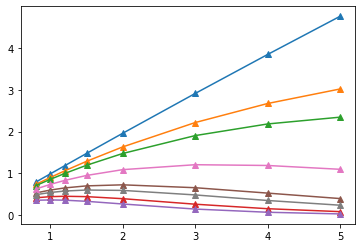

In [19]:
lam = [0.8, 1, 1.2, 1.5, 2, 3, 4, 5]
plt.plot(lam,res2[:, 1], marker='^')
plt.plot(lam, res2[:, 10], marker='^')
plt.plot(lam, res2[:, 15], marker='^')
plt.plot(lam, res2[:, 80], marker='^')
plt.plot(lam, res2[:, 99], marker='^')
plt.plot(lam, res2[:, 50], marker='^')
plt.plot(lam, res2[:, 30], marker='^')
plt.plot(lam, res2[:, 60], marker='^')

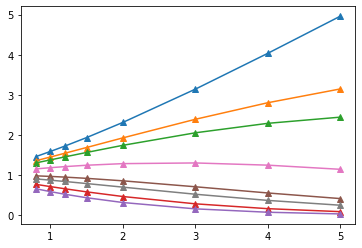

In [51]:
lam = [0.8, 1, 1.2, 1.5, 2, 3, 4, 5]
plt.plot(lam,res[:, 1], marker='^')
plt.plot(lam, res[:, 10], marker='^')
plt.plot(lam, res[:, 15], marker='^')
plt.plot(lam, res[:, 80], marker='^')
plt.plot(lam, res[:, 99], marker='^')
plt.plot(lam, res[:, 50], marker='^')
plt.plot(lam, res[:, 30], marker='^')
plt.plot(lam, res[:, 60], marker='^')

In [20]:
(decay.unsqueeze(2)-discretization*decay.unsqueeze(2)) 

tensor([3.0000e+00, 2.8811e+00, 2.7665e+00, 2.6563e+00, 2.5502e+00, 2.4480e+00,
        2.3497e+00, 2.2550e+00, 2.1639e+00, 2.0763e+00, 1.9919e+00, 1.9108e+00,
        1.8327e+00, 1.7575e+00, 1.6852e+00, 1.6157e+00, 1.5488e+00, 1.4845e+00,
        1.4226e+00, 1.3631e+00, 1.3059e+00, 1.2509e+00, 1.1980e+00, 1.1471e+00,
        1.0982e+00, 1.0513e+00, 1.0061e+00, 9.6269e-01, 9.2098e-01, 8.8091e-01,
        8.4241e-01, 8.0542e-01, 7.6989e-01, 7.3576e-01, 7.0298e-01, 6.7151e-01,
        6.4128e-01, 6.1227e-01, 5.8441e-01, 5.5767e-01, 5.3201e-01, 5.0738e-01,
        4.8375e-01, 4.6108e-01, 4.3933e-01, 4.1847e-01, 3.9846e-01, 3.7927e-01,
        3.6087e-01, 3.4324e-01, 3.2633e-01, 3.1013e-01, 2.9461e-01, 2.7973e-01,
        2.6548e-01, 2.5183e-01, 2.3876e-01, 2.2625e-01, 2.1427e-01, 2.0281e-01,
        1.9183e-01, 1.8134e-01, 1.7129e-01, 1.6169e-01, 1.5251e-01, 1.4373e-01,
        1.3534e-01, 1.2732e-01, 1.1966e-01, 1.1234e-01, 1.0535e-01, 9.8685e-02,
        9.2321e-02, 8.6248e-02, 8.0455e-

In [3]:
dim = 2
baseline = torch.tensor([1., 2.])
decay = torch.tensor([[2, 3], [1., 1]])
adjacency = torch.tensor([[1, 0.3], [0.1, 0.2]])
#baseline = torch.ones(dim)
#decay = torch.ones(dim,dim)
#adjacency = torch.ones(dim,dim)
upper = 1
L = 100
T= 10000
G = T*L
Delta = 1/L
discret = torch.linspace(0, 1, L)

d1 = torch.zeros(L*T)
d2 = torch.zeros(L*T)
d1[::5] = 1.
d1[::2] = 2.
kappa=1
d2[::3] = kappa
events_torch = [d1, d2]
events_np = [d1.numpy(), d2.numpy()]

#### True intensity
model = KernelExpDiscret(decay,  upper, 0.01)
kernel_values_2 = model.eval(discret)
intens = model.intensity_eval(baseline, adjacency, events_torch)

true_term1 = ((intens**2).sum(1) * (Delta/2)).sum() / T

print(true_term1.sum())

mask1 = torch.zeros(T*L, dtype=torch.int64)
mask2 = torch.zeros(T*L, dtype=torch.int64)
mask1[::5] = 1
mask1[::2] = 2
mask2[::3] = kappa
mask = torch.stack((mask1, mask2))

true_term2 = ((intens*mask).sum(1) / T).sum()
loss = true_term2+true_term1
print(loss)

tensor(4.7889)
tensor(318.1396)


In [4]:
true_term2

tensor(313.3507)

In [5]:
def kernel_eval(decay, upper, grid):
    """Return kernel evaluate on the discretisation grid: time
    kernel_values:  tensor de taille (dim x dim x len(time))"""

    kernel_values = decay.unsqueeze(2) * torch.exp(-decay.unsqueeze(2)*grid)
    mask_kernel = (grid <= 0) | (grid > upper)
    kernel_values[:, :, mask_kernel] = 0.
    kernel_values /= kernel_values.sum(2)[:, :, None] # intéret de * dt ?

    return kernel_values

In [6]:
def const(Delta, T):
    return (0.5 * Delta)/ T

def term1_(G, Delta, T, baseline):
    return G * const(Delta, T) * (np.linalg.norm(baseline, 2)**2)

#term2 valid
def term2_(baseline, kernel, events, L):   
    res = 0
    const1 = get_zG(np.vstack(events), L)
    for i in range(dim):
        temp = 0
        for j in range(dim):
            temp += adjacency[i, j] * const1[j]@kernel[i, j]
            
        res += baseline[i] * temp
    return 2 * const(Delta, T) * res.item()


In [7]:
def term3_(kernel, adjacency, events, L):
    
    const2_ = get_ztzG(np.vstack(events), L)

    res = 0
    for i in range(dim):
        for k in range(dim):
            for j in range(dim):
                temp = adjacency[i, j] * adjacency[i, k]
                temp2 = 0
                for tau in range(L):
                    for tau_p in range(L):
                        temp2 += (kernel[i, j, tau] 
                         * kernel[i, k, tau_p]) * const2_[j, k, tau, tau_p]
                       
                res += temp * temp2
    return  const(Delta, T) * res.item()

In [8]:
def term4_(kernel, adjacency, events, L):
    
    const1p = get_zN(np.vstack(events), L)
    res = 0
    for i in range(dim):
        res += baseline[i] * events[i].sum()
        for j in range(dim):
            alphaij = adjacency[i,j]
            temp = const1p[i, j]@kernel[i, j]
            res += temp * alphaij

    return (res / T).item()

In [9]:
kernel = kernel_eval(decay, upper, discret).numpy()
start = time.time()
term_1_ = term1_(G, Delta, T, baseline)
print('term 1 is:', term_1_)
#zG = get_zG(np.vstack(events_np), L)
term_2_ = term2_(baseline, kernel, events_np, L)
print('term 2 is:', term_2_)
#ztzG = get_ztzG(np.vstack(events_np), L)
term_3_ = term3_(kernel, adjacency, events_np, L)
print('term 3 is:', term_3_)
#zN = get_zN(np.vstack(events_np), L)
n_events = torch.stack(events_torch).sum(1)
term_4_ = term4_(kernel, adjacency, events_np, L)
print('term 4 is:', term_4_)
print('computation time in', time.time() - start)

term 1 is: 2.50000007341103
term 2 is: 1.553278601026053
term 3 is: 0.7356644375
term 4 is: 313.3507080078125
computation time in 2.260101079940796


In [10]:
term_1_ + term_2_ + term_3_ - term_4_

-308.5617648958754

In [11]:
kernel = kernel_eval(decay, upper, discret).numpy()
start = time.time()
term_1 = term1(baseline)
print('term 1 is:', term_1)
zG = get_zG(np.vstack(events_np), L)
term_2 = term2(zG, baseline, adjacency, kernel)
print('term 2 is:', term_2)
ztzG = get_ztzG(np.vstack(events_np), L)
term_3 = term3(ztzG, kernel, adjacency)
print('term 3 is:', term_3)
zN = get_zN(np.vstack(events_np), L)
n_events = torch.stack(events_torch).sum(1)
term_4 = term4(zN, kernel, baseline, adjacency, n_events)
print('term 4 is:', term_4)
print('computation time in', time.time() - start)

term 1 is: 2.5
term 2 is: 1553278.5
term 3 is: 1471328.875
term 4 is: 3133507.0
computation time in 2.120910167694092


In [12]:
l2loss_precomputation(zG, zN, ztzG, kernel,
                      baseline, adjacency,
                      n_events, 0.01,
                      T)

2.5
1.5532785
0.7356644375
313.35069999999996


-308.56175706249996

In [2]:
end_time = 10000
n_dim = 2
delta = 0.01
n_discrete = 100
random_state = None

rng = check_random_state(random_state)

d1 = torch.zeros(n_discrete*end_time, dtype=torch.float64)
d2 = torch.zeros(n_discrete*end_time, dtype=torch.float64)
idx1 = rng.choice(np.arange(n_discrete*end_time), int(end_time/10))
idx2 = rng.choice(np.arange(n_discrete*end_time), int(end_time/7))
d1[idx1] = 1.
d2[idx2] = 2.
d1[idx2] = 3.
events_torch = [d1, d2]
events = torch.stack(events_torch)
discrete = torch.linspace(0, 1, n_discrete)
baseline = torch.tensor(rng.randn(n_dim))
adjacency = torch.tensor(rng.randn(n_dim, n_dim))
decay = torch.tensor(rng.randn(n_dim, n_dim))
n_events = events.sum(1)



model = KernelExpDiscret(decay, 1, delta)
kernel = model.eval(discrete)
intens = model.intensity_eval(baseline, adjacency, events)
right_term_conv = (intens*events).sum() / end_time


zG = torch.tensor(get_zG(events.numpy(), n_discrete))
zN = torch.tensor(get_zN(events.numpy(), n_discrete))
ztzG = torch.tensor(get_ztzG(events.numpy(), n_discrete))


grad_alpha = get_grad_alpha(zG, zN, ztzG, baseline, adjacency,
               kernel, delta, end_time)


In [12]:
adjacency = torch.tensor(rng.randn(n_dim, n_dim)).requires_grad_(True)
loss = l2loss_precomputation(zG, zN, ztzG, 
                      baseline, adjacency, kernel,
                      n_events, 0.01,
                      end_time)

In [2]:
kernel_model = 'KernelExpDiscret'
baseline = torch.tensor([1.1, 1.3])
kernel_params = torch.tensor([[2, 3], [8, 4]])
adjacency = torch.tensor([[1, 0.3], [0.1, 0.4]])
end_time = 5
discret_step = 0.1
events = [torch.tensor([0.7653, 0.76187, 2.323, 2.1]),torch.tensor([3.653, 2.76187, 4.323, 3.1]) ]
solver = HawkesDiscretL2(kernel_model, kernel_params, 
                 baseline,  adjacency, discret_step,
                 solver='RMSprop', step_size=1e-3,
                 max_iter=100, log=False,
                 random_state=None, device='cpu')

In [3]:
solver.toy(torch.stack(events), 10)

torch.Size([2, 100])
tensor([1.1000, 1.3000], requires_grad=True)


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [ ]:
%debug

> /Users/guillaumestaerman/Desktop/PostDoc/hawkes_discret/hawkes_discret/loss_and_gradient.py(92)term2()
     90         temp = 0
     91         for j in range(n_dim):
---> 92             temp += adjacency[i, j] * (zG[j] @ kernel[i, j])
     93         res += baseline[i] * temp
     94 

ipdb> zG.dtype
torch.float64
ipdb> kernel.dtype
torch.float32


In [30]:
torch.isclose(2,3)

TypeError: isclose(): argument 'input' (position 1) must be Tensor, not int

In [18]:
events_torch[0].shape

torch.Size([1000000])

In [36]:
dim

10

In [77]:
#validation term3
D__ = compute_deux_(events_np, L)
i, j, k = 0, 1, 1
dim = 2
conv = 0
somme = 0
idx=np.arange(L)
D2_nodiag = D__.copy()
D2_nodiag[:, :, idx, idx] = 0
D2_ = np.transpose(D2_nodiag, axes=(1, 0, 3, 2)) + D__



for tau in range(L):
    for tau_p in range(L):
        somme += (kernel[i, j, tau] 
         * kernel[i, k, tau_p]) * D2_[j, k, tau, tau_p]
        
convij = torch.conv_transpose1d(events_torch[j].view(1, G),
                        kernel_values_2[i, j].view(1, 1, L))[:, :-L+1]
convik = torch.conv_transpose1d(events_torch[k].view(1, G),
                        kernel_values_2[i, k].view(1, 1, L))[:, :-L+1]


print(torch.abs((convij * convik).sum()- somme.sum()))

tensor(4.7748e-12, dtype=torch.float64)


In [8]:
#validation term2
D = get_zG(np.array(events_np), L)
i, j = 1, 0
dim = 2
conv = 0
somme = 0
for i in range(dim):
    for j in range(dim):
        somme += adjacency[i,j] *torch.tensor(D[j], dtype=torch.float64)@kernel_values_2[i,j]
        conv += adjacency[i,j] * torch.conv_transpose1d(
                        events_torch[j].view(1, G),
                        kernel_values_2[i, j].view(1, 1, L))[:, :-L+1]        
print((torch.abs(conv.sum()-somme.sum())))

tensor(0., dtype=torch.float64)


In [10]:
#validation term4
D_ = compute_un_prime_(events_np, L)
somme = 0
conv = 0
conv2 = 0
dim=2
timestamps = []
for i in range(dim):
    timestamps.append(np.where(events_np[i] > 0)[0])
    for j in range(dim):
        somme += adjacency[i,j] * torch.tensor(D_[i, j], dtype=torch.float64)@kernel_values_2[i,j]

        temp = adjacency[i,j] * torch.conv_transpose1d(
                        events_torch[j].view(1, G),
                        kernel_values_2[i, j].view(1, 1, L))[:, :-L+1]
        conv += temp.squeeze()[timestamps[i]].sum()
        temp = adjacency[i,j] * kernel_values_2[i, j]
        temp2 = torch.conv_transpose1d(
                        events_torch[j].view(1, G),
                        temp.view(1, 1, L))[:, :-L+1]
        conv2 += temp2.squeeze()[timestamps[i]].sum()
        
print((torch.abs(conv-somme.sum())))
print((torch.abs(conv2.sum()-somme.sum())))

tensor(4.5475e-13, dtype=torch.float64)
tensor(4.5475e-13, dtype=torch.float64)


In [3]:
from hawkes_discret.kernels import KernelExpDiscret
from hawkes_discret.hawkes_discret_l2 import HawkesDiscretL2
import torch
import numpy as np
import matplotlib.pyplot as plt
import time
kernel_model = 'KernelExpDiscret'
baseline = torch.tensor([1.1, 1.3])
kernel_params = torch.tensor([[2, 3], [8, 4]])
adjacency = torch.tensor([[1, 0.3], [0.1, 0.4]])
end_time = 5
discret_step = 0.1
d1

tensor([2., 0., 2.,  ..., 0., 2., 0.], dtype=torch.float64)

In [4]:
model = KernelExpDiscret(kernel_params, 1, 0.01)

In [5]:
%time
kernel_values = model.eval(discret)

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 10 µs


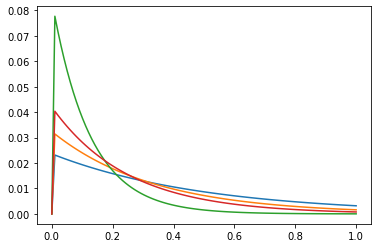

In [12]:
for i in range(dim):
    for j in range(dim):
        plt.plot(discret, kernel_values[i,j])

In [7]:
%time
intens = model.intensity_eval(baseline, adjacency, torch.stack(events_torch))


CPU times: user 7 µs, sys: 1e+03 ns, total: 8 µs
Wall time: 14.8 µs


In [8]:
lossl2_conv(intens, torch.stack(events_torch), 0.01, T)

tensor(-299.2478, dtype=torch.float64)

In [8]:
%time
model.integrate()

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 16.2 µs


tensor([[1.0000, 1.0000],
        [1.0000, 1.0000]])

In [9]:
%time
model.grad_params(time).shape

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.87 µs


torch.Size([2, 2, 100])

In [4]:
from hawkes_discret.kernels import KernelExpDiscret
from hawkes_discret.hawkes_discret_l2 import HawkesDiscretL2
import torch
import numpy as np
import matplotlib.pyplot as plt
import time
kernel_model = 'KernelExpDiscret'
baseline = torch.tensor([1.1, 1.3])
kernel_params = torch.tensor([[2, 3], [8, 4]])
adjacency = torch.tensor([[1, 0.3], [0.1, 0.4]])
end_time = 5
discret_step = 0.1
events = [torch.tensor([0.7653, 0.76187, 2.323, 2.1]),torch.tensor([3.653, 2.76187, 4.323, 3.1]) ]
solver = HawkesDiscretL2(kernel_model, kernel_params, 
                 baseline,  adjacency, discret_step,
                 solver='RMSprop', step_size=1e-3,
                 max_iter=100, log=False,
                 random_state=None, device='cpu')